## RECONOCIMIENTO DE PATRONES - TYPES OF GLASS

## READ THE DATA

In [1]:
import pandas as pd


In [2]:
input_folder = "./input/"
glass_csv = "glassInputs.csv"
targets_csv = "glassTargets.csv"


In [3]:
def read_data(file_name):
    data = pd.read_csv(file_name)
    return data


glass_data = read_data(input_folder + glass_csv)
targets_data = read_data(input_folder + targets_csv)


---
---

## DEAP CONFIGURATION

In [4]:
import operator
import math
import random

# Import deap gp and tools
from deap import gp, base, tools, creator, algorithms


In [5]:
def protectedDiv(left, right):
    return 1 if right == 0 else left / right


#### INDIVIDUAL

In [6]:
def config_individual():
    # Create primitive set
    pset = gp.PrimitiveSet("MAIN", 1)

    # Add all primitives to the primitive set
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)

    """
    A constant (random) value to include in the tree is added: it allows to include in the functions other operands.
    """
    pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))

    """
    An argument is added for the function to be evaluated (in our problem there is only one: the 'x' of the function). 
    That is, given an x, you are asked to calculate the corresponding y.
    If the function needs more input parameters, they are added here
    """
    pset.renameArguments(ARG0="x")

    return pset


#### TEST INDIVIDUAL

In [7]:
def test_individual():
    pset = config_individual()
    expr = gp.genFull(pset, min_=1, max_=3)
    tree = gp.PrimitiveTree(expr)
    print(tree)


## POPULATION CONFIGURATION

#### POPULATION

In [8]:
def config_population(toolbox):
    # Create fitness and individual.
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", gp.PrimitiveTree,
                       fitness=creator.FitnessMin)

    pset = config_individual()

    # Register expr, individual, population and compile in toolbox
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
    toolbox.register("individual", tools.initIterate,
                     creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    return pset


#### TEST POPULATION

In [9]:
def test_population():
    toolbox = base.Toolbox()
    config_population(toolbox)
    pop = toolbox.population(n=10)

    for ind in pop:
        print(gp.PrimitiveTree(ind))


---
---

#### DATA (TEMPORAL)

In [10]:
def fCuarta():
    entradas = [x/10. for x in range(-10, 10)]
    salidas = [x**4 - x**3 - x**2 - x for x in entradas]

    return entradas, salidas


#### TEST DATA (TEMPORAL)

In [11]:
def prueba():
    entradas, salidas = fCuarta()

    for x, y in zip(entradas, salidas):
        print("x=", x, "y=", y)


## EVALUATION

In [12]:
def eval_eq(toolbox, individual):
    # Se calcula el error cuadrático medio que comete la función
    # al evaluarse sobre los diferentes datos
    # El ECM se calcula como:

    entradas, salidas = fCuarta()
    func = toolbox.compile(expr=individual)

    sqerrors = []
    for x, y in zip(entradas, salidas):
        sqerrors.append((func(x) - y)**2)

    return (math.fsum(sqerrors) / len(entradas)),


#### PLOT TREE

In [13]:
def plot_tree(toolbox, individual):

    nodes, edges, labels = gp.graph(individual)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()


#### TEST EVALUATION

In [14]:
def test_evaluation():
    toolbox = base.Toolbox()
    config_population(toolbox)
    ind = toolbox.individual()

    tree = gp.PrimitiveTree(ind)
    print(tree)
    print(ind.fitness.valid)

    ind.fitness.values = eval_eq(toolbox, ind)

    print(ind.fitness.valid)
    print(ind.fitness)


---
---

## EVOLUTION CYCLE

In [15]:
def config_algorithm(toolbox, pset):
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    toolbox.decorate("mate", gp.staticLimit(
        key=operator.attrgetter("height"), max_value=17))
    toolbox.decorate("mutate", gp.staticLimit(
        key=operator.attrgetter("height"), max_value=17))

    toolbox.register("evaluate", eval_eq, toolbox)


In [16]:
def make_evolution(stats):
    toolbox = base.Toolbox()
    pset = config_population(toolbox)
    config_algorithm(toolbox, pset)

    pop = toolbox.population(n=50)

    CXPB, MUTPB, NGEN = 0.5, 0.2, 30

    pop, logbook = algorithms.eaSimple(
        pop, toolbox, verbose=False, stats=stats,
        cxpb=CXPB, mutpb=MUTPB, ngen=NGEN)

    best = tools.selBest(pop, 1)[0]

    print(logbook)
    print("La mejor solucion encontrada es: ")
    print(best)
    
    return logbook


#### TEST EVOLUTION CYCLE

In [17]:
# make_evolution([])

---
---

## STATS

In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def show_stats(log):
    gen = log.select("gen")
    avgs = log.select("avg")

    _, ax1 = plt.subplots()

    _ = ax1.plot(gen, avgs, "r-", label="Average Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")

    plt.plot()


gen	nevals	avg     	std     	min      	max    
0  	50    	2.16141 	2.71758 	0.173221 	15.1059
1  	31    	1.38739 	1.41833 	0.0873516	9.74039
2  	32    	0.986457	0.968525	0.0873516	5.72309
3  	29    	1.29475 	2.48327 	0.0804148	17.4095
4  	29    	0.992299	2.33527 	0.0804148	16.1829
5  	29    	0.797326	1.04805 	0.0804148	5.18199
6  	31    	0.646269	0.717737	0.0804148	2.32654
7  	31    	0.600498	0.963134	0.0804148	5.64517
8  	35    	0.538311	0.788457	0.0804148	4.48857
9  	29    	0.865411	2.17335 	0.0746178	15.0009
10 	32    	0.620892	0.982592	0.0746178	5.00128
11 	35    	0.460764	0.624907	0.0746178	2.82102
12 	32    	0.312919	0.438813	0.0746178	1.86459
13 	39    	1.414   	4.32858 	0.0766738	27.5106
14 	31    	0.581297	0.603985	0.0735436	2.32654
15 	24    	0.438635	0.732978	0.0735436	4.07265
16 	32    	0.423717	0.592042	0.0735436	3.3632 
17 	21    	0.376901	0.575575	0.0732003	3.04697
18 	38    	0.650984	0.82404 	0.0730081	4.32878
19 	33    	0.565204	1.02592 	0.0732003	5.54486
20 	33    	0.

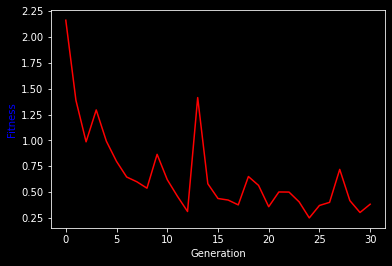

In [20]:
log = make_evolution(stats)
show_stats(log)